In [36]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models, layers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
def windowing(x, y, window_size, overlap):
    num_windows = ((x.shape[1] - window_size) // overlap) + 1
    y_window = []
    windows = np.zeros((num_windows*x.shape[0], window_size, x.shape[2]))
    for dataset in range(x.shape[0]):
        for i in range(num_windows):
            y_window.append(y[dataset])
            start = i * overlap
            end = start + window_size
            windows[i, :, :] = x[dataset, start:end, :]
    return windows, np.array(y_window)

In [3]:
absolutepath = '/Users/helenamehler/PycharmProjects/fallDetection/dataSets/FallAllD_Labelled'

In [4]:
x_train = []
y_train = []
x_test = []
y_test = []

for root, dirs, files in os.walk(absolutepath):
    for file in files:
        if "acc" in file:
            filepath = os.path.join(root, file)
            df = pd.read_csv(filepath)
            features = df[['accelerometer_x', 'accelerometer_y', 'accelerometer_z']]
            label = df['fall'][0]

            if np.random.rand(1)[0] < 0.2:
                x_test.append(features.values)
                y_test.append(label)
            else:
                x_train.append(features.values)
                y_train.append(label)


In [5]:
scaler = MinMaxScaler()

x_train = np.array(x_train)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)

x_test = np.array(x_test)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [21]:
window_size = 200
overlap = 50

x_train_w, y_train_w = windowing(x_train, y_train, window_size, overlap)
x_test_w, y_test_w = windowing(x_test, y_test, window_size, overlap)

In [30]:
y_trainCat = to_categorical(y_train, num_classes=2)

In [31]:
input = (x_train.shape[1], x_train.shape[2])
model = models.Sequential()
model.add(layers.Conv1D(6, kernel_size=4, activation='relu', input_shape=input, padding='same'))

model.add(layers.MaxPooling1D(pool_size=4, strides=4))

model.add(layers.Conv1D(12, kernel_size=4, activation='relu',padding='same'))

model.add(layers.MaxPooling1D(pool_size=4, strides=4))
model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
batch = 80
epochs = 40
iterationsPerEp = x_train.shape[0] // batch
model.fit(x_train, y_trainCat, batch_size=batch, epochs=epochs, steps_per_epoch=iterationsPerEp)

Epoch 1/40
16/16 [==============================] - 1s 23ms/step - loss: 0.7755 - accuracy: 0.6289
Epoch 2/40
16/16 [==============================] - 0s 21ms/step - loss: 0.6060 - accuracy: 0.7106
Epoch 3/40
16/16 [==============================] - 0s 19ms/step - loss: 0.5952 - accuracy: 0.7139
Epoch 4/40
16/16 [==============================] - 0s 19ms/step - loss: 0.5855 - accuracy: 0.7139
Epoch 5/40
16/16 [==============================] - 0s 19ms/step - loss: 0.5907 - accuracy: 0.6925
Epoch 6/40
16/16 [==============================] - 0s 23ms/step - loss: 0.5225 - accuracy: 0.7494
Epoch 7/40
16/16 [==============================] - 0s 20ms/step - loss: 0.5243 - accuracy: 0.7312
Epoch 8/40
16/16 [==============================] - 0s 21ms/step - loss: 0.4806 - accuracy: 0.7535
Epoch 9/40
16/16 [==============================] - 0s 20ms/step - loss: 0.4340 - accuracy: 0.7955
Epoch 10/40
16/16 [==============================] - 0s 19ms/step - loss: 0.4121 - accuracy: 0.8104
Epoch 11/

In [33]:
predictions = model.predict(x_test)
yPredClasses = np.argmax(predictions, axis=1)
confMat = confusion_matrix(y_test, yPredClasses)
confMat

11/11 [==============================] - 0s 5ms/step


array([[244,   9],
       [ 11,  71]])

In [34]:
print('Accuracy', accuracy_score(y_test, yPredClasses))
print('F1-Score', f1_score(y_test, yPredClasses))

Accuracy 0.9402985074626866
F1-Score 0.8765432098765432


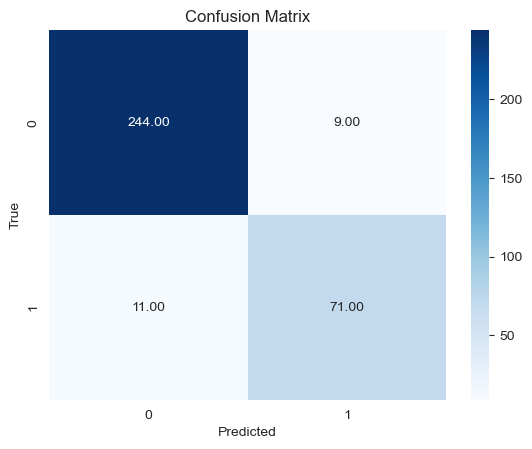

In [41]:
plt.figure()
sns.heatmap(confMat.astype('int') , annot=True, fmt='0.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()